## PyTorch MLP model

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import ast
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

### Loading training set and blind test set

In [2]:
df_visual = pd.read_csv('./data/ML-CUP21-TR.csv', usecols=[11,12], names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = pd.read_csv('./data/ML-CUP21-TR.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = df_task_tr[7:] # remove first 7 rows of comments
df_visual = df_visual[7:]

df_blind_ts = pd.read_csv('./data/ML-CUP21-TS.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10'])
df_blind_ts = df_blind_ts[7:]
df_blind_ts.drop(labels="idx", axis=1, inplace=True)
blind_ts = df_blind_ts.values

### Evaluation metric and tools

We define the <b>MEE (Mean Euclidean Error)</b> function which is used to evaluate the mean euclidean distance between two points with x and y coordinates.
The function takes in input the true target and the predicted target and yields a floating point number which represents the performance. 

In [3]:
def mee(true_target, predicted_target): #assuming target is 2-dim matrix with x and y as columns
    l = true_target.shape[0]
    res = 0
    
    for p in range(l): #for p-th pattern in l (number of samples)
        x_diff = np.square(true_target[p,0] - predicted_target[p,0]) #difference between the x value of the true and predicted target
        y_diff = np.square(true_target[p,1] - predicted_target[p,1]) #difference between the y values of true and predicted target
        sum_term = x_diff + y_diff
        res = res + np.sqrt(sum_term)
    res = res / l
    
    #return np.average([np.sqrt(np.square(true_target[p,0] - predicted_target[p,0]) + np.square(true_target[p,1] - predicted_target[p,1])) for p in range(l)]) #compact form
    return res

In [4]:
def plot_learning_curves(train_scores, test_scores, epochs, y_label, ax, i):
    ax.set_title(f"Model {i+1}")
    ax.set_ylabel(y_label)
    ax.set_xlabel('Epoch');
    ax.plot(range(0,epochs), train_scores, label = "Training error", linestyle='dashed')
    ax.plot(range(0,epochs), test_scores, label = "Test error")
    ax.legend()

    return ax

In [5]:
def plot_coordinates(y_predicted, true_y = None):
    y_predicted = pd.DataFrame(data=y_predicted, columns=["x", "y"])
    if not None:
        true_y = pd.DataFrame(data=true_y, columns=["x", "y"])
        plt.scatter(true_y['x'], true_y['y'], c='r', marker='*')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4')

In [6]:
#trains the model with one iteration (epoch) and computes in output a list of train and test scores using MEE
def fit_and_score(epochs, eval_model, X_train, y_train, X_test, y_test):
    train_scores = []
    test_scores = []
    train_loss = []
    test_loss = []
    eval_model.initialize()
    for i in range(epochs):
        eval_model = eval_model.fit_loop(X_train,y_train,1) #single epoch of the model
        y_train_predicted = eval_model.predict(X_train)
        y_test_predicted = eval_model.predict(X_test)
        #results on train set
        train_scores.append(mean_squared_error(y_train, y_train_predicted))
        test_scores.append(mean_squared_error(y_test, y_test_predicted))
        #result on test set
        train_loss.append(mee(y_train, y_train_predicted))
        test_loss.append(mee(y_test, y_test_predicted))
    return train_scores, test_scores, train_loss, test_loss


## Regression task
### Preparing the training set

In [7]:
df_task_tr.drop(labels="idx", axis=1, inplace=True)

In [8]:
y = df_task_tr[['x','y']].values
X = df_task_tr.drop(labels=['x','y'], axis=1).values

In [9]:
print(X.shape)
print(y.shape)

(1477, 10)
(1477, 2)


In [10]:
RS_NUMBER = 69

### Splitting the dataset
We split the data set obtaining an internal test set (10% of the total dataset), we will use this internal test at the end to test internally the generalization error.

In [11]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=RS_NUMBER)

print(f"X train shape: {X.shape}")
print(f"X validation shape: {X_test.shape}")
print(f"y train shape: {y.shape}")
print(f"y validation shape: {y_test.shape}")

X train shape: (1329, 10)
X validation shape: (148, 10)
y train shape: (1329, 2)
y validation shape: (148, 2)


### Define the module for the neural network
We define a Module for PyTorch, which takes as input the number of units, activation function (sigmoid, relu or tanh) and the number of hidden layers (can be either one or two). The model architecture is the simplest one of a MLP, one or two linear layers and the activation function.  

In [12]:
class MyModule(nn.Module):
    def __init__(self, num_units, activation_fun, hidden_layers):
        super(MyModule, self).__init__()
        
        if(activation_fun == "sigmoid"):
            activation_fun = nn.Sigmoid()
        elif activation_fun == "relu":
            activation_fun = nn.ReLU()
        elif activation_fun == "tanh":
            activation_fun = nn.Tanh()
            
        if hidden_layers == 2:
            self.linear_stack = nn.Sequential(
                nn.Linear(10, num_units),
                activation_fun,
                nn.Linear(num_units, num_units),
                activation_fun,
                nn.Linear(num_units, 2),
            )
        elif hidden_layers == 1:
            self.linear_stack = nn.Sequential(
                nn.Linear(10, num_units),
                activation_fun,
                nn.Linear(num_units, 2),
            )     
    def forward(self, x):
        X = self.linear_stack(x)
        return X
    
    def predict(self, x):
        X = self.linear_stack(x)
        return X

We define the device where the computation is going to happen (in our case the CPU) and we print a model example with a single hidden layer with 100 hidden units and the sigmoid activation function.  

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

example = MyModule(num_units=100, activation_fun = "sigmoid", hidden_layers = 1).to(device)
print(example)

MyModule(
  (linear_stack): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=2, bias=True)
  )
)


Pytorch is used with skorch which is a wrapper for the framework, the goal of skorch is to make it possible to use PyTorch with sklearn. This will allow us to use the randomized search of sklearn, the NeuralNetRegressor takes the module defined before as input and a callback for the early stopping criteria.

In [14]:
PATIENCE=20
THRESHOLD=0.005

In [15]:
model = NeuralNetRegressor(
    module = MyModule,
    callbacks=[('early_stoppping', EarlyStopping(monitor='valid_loss', patience=PATIENCE, threshold=THRESHOLD))],
)

In [16]:
# define the number of iterations
n_iter_search = 1000
# define number of k-folds
k = 10

In [17]:
X = X.astype(np.float32)
y = y.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)
blind_ts = blind_ts.astype(np.float32)


### Randomized Search

In [18]:
%%time

%%script false --no-raise-error 

# to find the best set of parameter setting, we can run a randomized search

# define the parameters' values
params = {
    'lr': uniform(0.005, 0.5),
    'max_epochs': [1000], #upper bound of max number of epochs
    'optimizer': [torch.optim.SGD],
    'optimizer__momentum': [0.9, 0.95], ##optimizer__ indicates that it is a parameter of the optimizer
    'optimizer__weight_decay': uniform(0.0001, 0.1),
    'optimizer__nesterov': [False, True],
    'module__num_units': randint(5, 128), #module__ indicates that it is a parameter of the module
    'module__hidden_layers': [1,2],
    'module__activation_fun': ["sigmoid", "tanh", "relu"],
    'batch_size': randint(X.shape[0] / 2, X.shape[0]),
}

# define the grid search
rand_gs = RandomizedSearchCV(
    model,
    param_distributions=params,
    n_iter=n_iter_search,
    n_jobs=-1,
    scoring=make_scorer(mee), #scoring is based on the highest value so we use the inverse of the MEE loss function
    cv=k,
    random_state=RS_NUMBER,
    verbose=10
)
# run the grid search
rand_gs.fit(X, y)


CPU times: user 4.77 ms, sys: 3.2 ms, total: 7.97 ms
Wall time: 32.4 ms


In [19]:
%%script false --no-raise-error

df_results = pd.DataFrame(data=rand_gs.cv_results_) #trasform into a pandas dataframe
df_results.sort_values(by="rank_test_score", axis=0, ascending=False, inplace=True) #sort rank values in decreasing order 
df_results.dropna(inplace=True) #delete nan values 
df_results = df_results[:50] #keep only top 50 models
pd.DataFrame.to_csv(df_results, "pytorch_results/rand1_search.csv")

In [20]:
df_results = pd.read_csv("pytorch_results/rand1_search.csv")
df_results.head()

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_lr,param_max_epochs,param_module__activation_fun,param_module__hidden_layers,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,351,7.446227,2.060713,0.003304,0.000923,1085,0.010735,1000,tanh,2,...,1.275691,1.262708,1.314163,1.220637,1.130686,1.294009,1.103945,1.198900,0.089318,364
1,193,10.116814,3.360544,0.003474,0.000937,769,0.020812,1000,tanh,1,...,1.292053,1.246149,1.276624,1.166664,1.200362,1.345337,1.104683,1.200969,0.090827,363
2,151,11.149166,5.130889,0.003559,0.000902,828,0.041330,1000,sigmoid,2,...,1.210037,1.291456,1.308960,1.216286,1.088487,1.279617,1.111038,1.201109,0.074222,362
3,947,8.083070,0.983948,0.008913,0.013385,950,0.038793,1000,sigmoid,2,...,1.232823,1.261195,1.318966,1.216999,1.203594,1.284076,1.168397,1.211525,0.073953,361
4,378,5.247426,1.731788,0.008317,0.016002,894,0.054108,1000,sigmoid,1,...,1.282325,1.286623,1.301515,1.266445,1.185831,1.313239,1.073333,1.221029,0.081890,360


In [21]:
#get the best params for the grid search (cannot use rand_gs.best_estimator directly since it will yield the worst estimator based on MEE)
best_params = df_results['params'][0]
print(f"Mean error on the {k}-folds (MEE) on best model: {df_results['mean_test_score'][0]}\n")
print(f"Best params: {best_params}")

Mean error on the 10-folds (MEE) on best model: 1.1988997536400103

Best params: {'batch_size': 1085, 'lr': 0.010735108419990699, 'max_epochs': 1000, 'module__activation_fun': 'tanh', 'module__hidden_layers': 2, 'module__num_units': 24, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__momentum': 0.9, 'optimizer__nesterov': True, 'optimizer__weight_decay': 0.023253784042946125}


In [22]:
@dataclass
class GridSearchRanges:
    '''Class of keeping track of the min and max values for the hyperparameters tuning'''
    
    hidden_layers = []
    min_lr = 0
    max_lr = 0
    min_num_units = 0
    max_num_units = 0
    min_weight_decay = 0
    max_weight_decay = 0
    min_bs = 0
    max_bs = 0
    
    def set_ranges(self):

        self.hidden_layers = np.unique(df_results['param_module__hidden_layers'])
        self.hidden_layers = self.hidden_layers.ravel() #convert to array
        print(f"hidden layers: {self.hidden_layers}")

        self.min_lr = np.min(df_results['param_lr'])
        self.max_lr = np.max(df_results['param_lr'])
        print(f"learning rate: [{self.min_lr}, {self.max_lr}]")
        
        self.min_num_units = np.min(df_results['param_module__num_units'])
        self.max_num_units = np.max(df_results['param_module__num_units'])
        print(f"num units: [{self.min_num_units}, {self.max_num_units}]")

        self.min_weight_decay = np.min(df_results['param_optimizer__weight_decay'])
        self.max_weight_decay = np.max(df_results['param_optimizer__weight_decay'])
        print(f"weight decay: [{self.min_weight_decay}, {self.max_weight_decay}]")

        self.min_bs = np.min(df_results['param_batch_size'])
        self.max_bs = np.max(df_results['param_batch_size'])
        print(f"batch size: [{self.min_bs}, {self.max_bs}]")
    
    

In [23]:
gs = GridSearchRanges()
gs.set_ranges()

hidden layers: [1 2]
learning rate: [0.0051252612925107, 0.4212342239067483]
num units: [6, 125]
weight decay: [0.0013677428208289, 0.0933416914946407]
batch size: [677, 1302]


### Second Randomized Search using min e max values

In [24]:
%%time

%%script false --no-raise-error  Wall time: 48min 31s (Michele)

# to find the best set of parameter setting, we can run a randomized search

# define the parameters' values
params = {
    'lr': uniform(gs.min_lr, gs.max_lr),
    'max_epochs': [1000], #upper bound of max number of epochs
    'optimizer': [torch.optim.SGD],
    'optimizer__momentum': [0.9, 0.95], ##optimizer__ indicates that it is a parameter of the optimizer
    'optimizer__weight_decay': uniform(gs.min_weight_decay, gs.max_weight_decay),
    'optimizer__nesterov': [False, True],
    'module__num_units': randint(gs.min_num_units, gs.max_num_units), #module__ indicates that it is a parameter of the module
    'module__hidden_layers': [1,2],
    'module__activation_fun': ["sigmoid", "tanh", "relu"],
    'batch_size': randint(gs.min_bs, gs.max_bs),
}

# define the grid search
rand_gs = RandomizedSearchCV(
    model,
    param_distributions=params,
    n_iter=n_iter_search,
    n_jobs=-1,
    scoring=make_scorer(mee), #scoring is based on the highest value so we use the inverse of the MEE loss function
    cv=k,
    random_state=RS_NUMBER,
    verbose=10
)
# run the grid search
rand_gs.fit(X, y)


CPU times: user 96 µs, sys: 7.9 ms, total: 8 ms
Wall time: 11 ms


In [25]:
%%script false --no-raise-error

df_results = pd.DataFrame(data=rand_gs.cv_results_) #trasform into a pandas dataframe
df_results.sort_values(by="rank_test_score", axis=0, ascending=False, inplace=True) #sort rank values in decreasing order 
df_results.dropna(inplace=True) #delete nan values 
df_results = df_results[:50] #keep only top 50 models
pd.DataFrame.to_csv(df_results, "pytorch_results/rand2_search.csv")

In [26]:
df_results = pd.read_csv("pytorch_results/rand2_search.csv")
df_results.head()

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_lr,param_max_epochs,param_module__activation_fun,param_module__hidden_layers,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,762,6.234873,2.134285,0.003717,0.000802,688,0.027336,1000,tanh,1,...,1.251395,1.238852,1.274680,1.207144,1.140431,1.327470,1.108824,1.198688,0.076770,380
1,318,9.025635,2.638702,0.009938,0.014327,1267,0.016512,1000,tanh,1,...,1.286893,1.240209,1.447911,1.195227,1.087232,1.280742,1.134934,1.217874,0.103953,379
2,192,7.756208,3.225465,0.004234,0.000231,782,0.018447,1000,tanh,1,...,1.313349,1.258214,1.285110,1.311753,1.149677,1.322884,1.116459,1.218157,0.095427,378
3,203,6.783391,1.702048,0.020277,0.022309,928,0.062170,1000,sigmoid,2,...,1.267981,1.243497,1.350444,1.261128,1.149986,1.273194,1.132930,1.227379,0.062339,377
4,216,8.229548,2.310584,0.004525,0.000295,914,0.005231,1000,tanh,2,...,1.313864,1.308713,1.344589,1.240368,1.225085,1.356700,1.136441,1.252131,0.080555,376


In [27]:
%%time

#%%script false --no-raise-error
# define the parameters' values
params = {
    'lr': [0.025, 0.0273, 0.028, 0.029],
    'max_epochs': [1000], #upper bound of max number of epochs
    'optimizer': [torch.optim.SGD],
    'optimizer__momentum': [0.9], ##optimizer__ indicates that it is a parameter of the optimizer
    'optimizer__weight_decay': [0.01, 0.0115, 0.012],
    'optimizer__nesterov': [False, True],
    'module__num_units': [38, 40, 42], #module__ indicates that it is a parameter of the module
    'module__hidden_layers': [1],
    'module__activation_fun': ["tanh"],
    'batch_size': [660, 688, 700, 720],
}

# define the grid search
gs = GridSearchCV(
    model,
    param_grid=params,
    n_jobs=-1,
    scoring=make_scorer(mee),
    cv=k,
    verbose=10
)
# run the grid search
gs.fit(X, y)


Fitting 10 folds for each of 288 candidates, totalling 2880 fits


In [28]:
%%script false --no-raise-error

df_results = pd.DataFrame(data=gs.cv_results_) #trasform into a pandas dataframe
df_results.sort_values(by="rank_test_score", axis=0, ascending=False, inplace=True) #sort rank values in decreasing order 
df_results.dropna(inplace=True) #delete nan values 
df_results = df_results[:50] #keep only top 50 models
pd.DataFrame.to_csv(df_results, "pytorch_results/grid_search.csv")

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [ ]:
df_results = pd.read_csv("pytorch_results/grid_search.csv")
df_results.head()

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_lr,param_max_epochs,param_module__activation_fun,param_module__hidden_layers,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,69,5.982851,1.046947,0.009161,0.004658,660,0.0290,1000,tanh,1,...,1.236870,1.188137,1.254298,1.132090,1.097498,1.272636,1.056725,1.158886,0.078409,288
1,51,6.065013,1.299662,0.006659,0.003749,660,0.0280,1000,tanh,1,...,1.240190,1.193574,1.263146,1.140539,1.110547,1.256757,1.073416,1.163493,0.073940,287
2,70,5.702571,1.201309,0.009409,0.008673,660,0.0290,1000,tanh,1,...,1.226554,1.187384,1.264649,1.115085,1.125793,1.288092,1.051342,1.165296,0.076212,286
3,21,6.068444,1.046621,0.006312,0.003739,660,0.0273,1000,tanh,1,...,1.280395,1.200526,1.268342,1.154747,1.105000,1.263425,1.066628,1.167881,0.084202,285
4,33,5.816689,0.733741,0.008821,0.004987,660,0.0273,1000,tanh,1,...,1.254100,1.176557,1.265489,1.139522,1.126393,1.236376,1.092388,1.168113,0.068100,284


In [ ]:
best_models = list() #list of the top ten models of the final randomized search
eval_best_models = list()

for i in range(10):
    ### GET HYPERPARAMETERS AND FIX DICTIONARY
    best_params_i = df_results['params'][i]
    first_part = str(best_params_i.split("'optimizer': <class 'torch.optim.sgd.SGD'>, ", 1)[0]) #manually remove the optimizer parameter
    second_part = str(best_params_i.split("'optimizer': <class 'torch.optim.sgd.SGD'>, ", 1)[1])
    best_params_i = first_part+second_part
    best_params_i = ast.literal_eval(best_params_i)

    print(best_params_i)
    ### SET HYPERPARAMETERS ###
    HIDDEN_LAYERS = best_params_i['module__hidden_layers']
    NUM_UNITS = best_params_i['module__num_units']
    ACTIVATION_FUN = best_params_i['module__activation_fun']
    OPTIMIZER = 'SGD'
    LR = best_params_i['lr']
    WEIGHT_DECAY = best_params_i['optimizer__weight_decay']
    BATCH = best_params_i['batch_size']
    MAX_EPOCHS = best_params_i['max_epochs']
    NESTEROV = best_params_i['optimizer__nesterov']
    MOMENTUM = best_params_i['optimizer__momentum']

    ### DEFINE MODULES AND MODELS ###
    module_i = MyModule(NUM_UNITS, ACTIVATION_FUN, HIDDEN_LAYERS)
    eval_module_i = MyModule(NUM_UNITS, ACTIVATION_FUN, HIDDEN_LAYERS)

    model_i = NeuralNetRegressor(
        module = module_i,
        criterion=nn.MSELoss,
        max_epochs=MAX_EPOCHS,
        lr=LR,
        batch_size=BATCH,
        optimizer=torch.optim.SGD,
        optimizer__momentum=MOMENTUM,
        callbacks=[('early_stoppping', EarlyStopping(monitor='valid_loss', patience=PATIENCE, threshold=THRESHOLD))],
    )

    eval_model_i = NeuralNetRegressor(
        module = eval_module_i,
        criterion=nn.MSELoss,
        max_epochs=MAX_EPOCHS,
        lr=LR,
        batch_size=BATCH,
        optimizer=torch.optim.SGD,
        optimizer__momentum=MOMENTUM,
    )

    best_models.append(model_i)
    eval_best_models.append(eval_model_i)

{'batch_size': 660, 'lr': 0.029, 'max_epochs': 1000, 'module__activation_fun': 'tanh', 'module__hidden_layers': 1, 'module__num_units': 42, 'optimizer__momentum': 0.9, 'optimizer__nesterov': True, 'optimizer__weight_decay': 0.01}
{'batch_size': 660, 'lr': 0.028, 'max_epochs': 1000, 'module__activation_fun': 'tanh', 'module__hidden_layers': 1, 'module__num_units': 42, 'optimizer__momentum': 0.9, 'optimizer__nesterov': True, 'optimizer__weight_decay': 0.01}
{'batch_size': 660, 'lr': 0.029, 'max_epochs': 1000, 'module__activation_fun': 'tanh', 'module__hidden_layers': 1, 'module__num_units': 42, 'optimizer__momentum': 0.9, 'optimizer__nesterov': True, 'optimizer__weight_decay': 0.0115}
{'batch_size': 660, 'lr': 0.0273, 'max_epochs': 1000, 'module__activation_fun': 'tanh', 'module__hidden_layers': 1, 'module__num_units': 38, 'optimizer__momentum': 0.9, 'optimizer__nesterov': True, 'optimizer__weight_decay': 0.01}
{'batch_size': 660, 'lr': 0.0273, 'max_epochs': 1000, 'module__activation_fun

In [ ]:
#Wall time: 1min 6s (Michele)
epochs_best_models = list()

#fit every model
for model in best_models:
    model.fit(X,y)
    EPOCHS = len(model.history)
    epochs_best_models.append(EPOCHS)


    129        0.9900        0.9428  0.0305
    130        0.9886        0.9423  0.0340
    131        0.9873        0.9417  0.2004
    132        0.9860        0.9412  0.1050
    133        0.9847        0.9407  0.2887
    134        0.9834        0.9402  0.2031
    135        0.9821        0.9397  0.1960
    136        0.9808        0.9393  0.2747
    137        0.9796        0.9388  0.2058
    138        0.9784        0.9383  0.2063
    139        0.9772        0.9379  0.2020
    140        0.9759        0.9375  0.1095
    141        0.9747        0.9370  0.1908
    142        0.9736        0.9366  0.2066
    143        0.9724        0.9362  0.2002
    144        0.9712        0.9358  0.2052
    145        0.9701        0.9354  0.1003
    146        0.9689        0.9350  0.1202
    147        0.9678        0.9346  0.0918
    148        0.9666        0.9342  0.1958
    149        0.9655        0.9338  0.2847
    150        0.9644        0.9335  0.1280
    151        0.9633        0.9

In [ ]:
y_predictions_train = list()
y_predictions_internal_test = list()
y_predictions_blind_test = list()

#predictions on every model is averaged
for model in best_models:
    #prediction on TRAINING SET
    y_pred = model.predict(X)
    y_predictions_train.append(y_pred)
    
    #prediction on INTERNAL TEST SET
    y_pred = model.predict(X_test)
    y_predictions_internal_test.append(y_pred)

    #prediction on BLIND TEST SET
    y_pred = model.predict(blind_ts)
    y_predictions_blind_test.append(y_pred)

In [ ]:
#Wall time: 2min 21s (Michele)
loss_train_best_models = list()
loss_test_best_models = list()

for i in range(len(eval_best_models)):
    epochs = epochs_best_models[i]
    eval_model = eval_best_models[i]
    score_train, score_test, loss_train, loss_test = fit_and_score(epochs, eval_model, X, y, X_test, y_test)
    loss_train_best_models.append(loss_train)
    loss_test_best_models.append(loss_test)

    129        1.0327        0.9441  0.0331
    130        1.0316        0.9435  0.0897
    131        1.0304        0.9428  0.0828
    132        1.0293        0.9422  0.0923
    133        1.0282        0.9416  0.0954
    134        1.0271        0.9411  0.0242
    135        1.0260        0.9405  0.0252
    136        1.0250        0.9399  0.0941
    137        1.0239        0.9394  0.0873
    138        1.0229        0.9388  0.0862
    139        1.0219        0.9383  0.0252
    140        1.0208        0.9378  0.0264
    141        1.0198        0.9373  0.0946
    142        1.0189        0.9368  0.1295
    143        1.0179        0.9363  0.1874
    144        1.0169        0.9358  0.1917
    145        1.0159        0.9353  0.1054
    146        1.0150        0.9349  0.1223
    147        1.0141        0.9344  0.0309
    148        1.0131        0.9339  0.1244
    149        1.0122        0.9335  0.1995
    150        1.0113        0.9330  0.2056
    151        1.0104        0.9

## Learning Curves

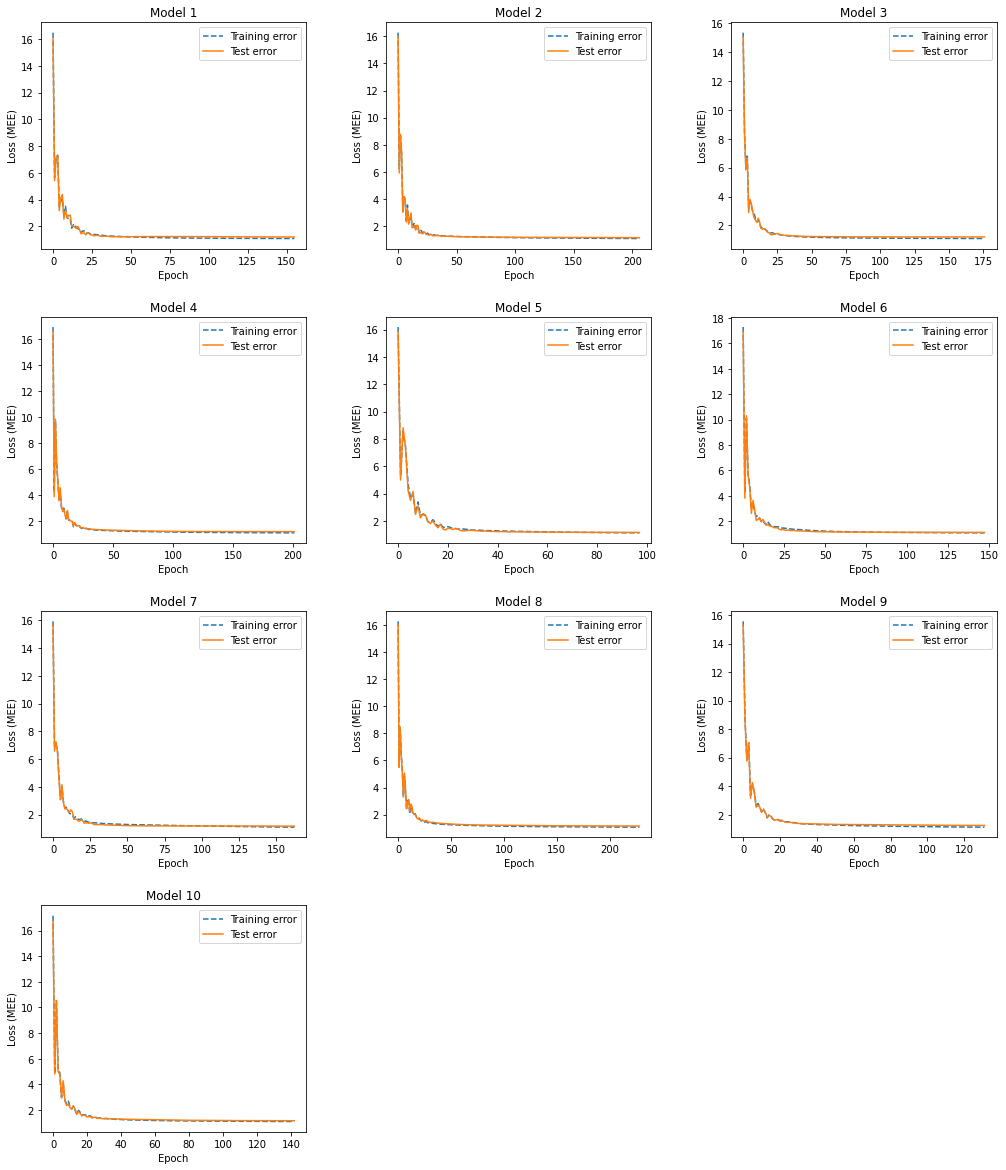

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(14,16))
axes = axes.flatten()
fig.tight_layout()

for i in range(len(eval_best_models)):
    epochs = epochs_best_models[i]
    loss_train = loss_train_best_models[i]
    loss_test = loss_test_best_models[i]
    plot_learning_curves(loss_train, loss_test, epochs, "Loss (MEE)", axes[i], i)

fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(wspace=0.3)
fig.delaxes(axes[10])
fig.delaxes(axes[11])

In [ ]:
### Predicted points on internal test set

In [ ]:
y_pred_voting_ens_train_test = np.average(y_predictions_train, axis=0)
y_pred_voting_ens_internal_test = np.average(y_predictions_internal_test, axis=0)
y_pred_voting_ens_blind_test = np.average(y_predictions_blind_test, axis=0)

print(f"MEE: {mee(y_test, y_pred_voting_ens_internal_test)}")

MEE: 1.1163543410901282


In [ ]:
plot_coordinates(y_predicted_test, y_test)

NameError: name 'y_predicted_test' is not defined

In [ ]:
plot_coordinates(y_predicted, y)

### Predicted points on blind test set

In [ ]:
plot_coordinates(y_predicted_blind)

## Ensemble 

Then we try the voting method using the 10 best models from the randomized search. 

In [ ]:
y_predicted = pd.DataFrame(data=y_pred_voting_ens_internal_test, columns=["x", "y"])
true_y = pd.DataFrame(data=y_test, columns=["x", "y"])
plt.scatter(true_y['x'], true_y['y'], c='r', marker='*')
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4');

In [ ]:
y_predicted = pd.DataFrame(data=y_pred_voting_ens_internal_test, columns=["x", "y"])
true_y = pd.DataFrame(data=y_test, columns=["x", "y"])
plt.scatter(true_y['x'], true_y['y'], c='r', marker='*')
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4');

In [ ]:
y_predicted = pd.DataFrame(data=y_pred_voting_ens_blind_test, columns=["x", "y"])
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4');

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d9d840c9-75b3-4185-bb01-105f5cca8d83' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>